## Creating a ML pipeline using scikit-learn

In [1]:
# Let's see our train data
import pandas as pd


train_data = pd.read_csv("datasets/train.csv")
train_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,710,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C,1
1,440,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.00,0,0,C.A. 18723,10.5000,NaN,S,0
2,841,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.00,0,0,SOTON/O2 3101287,7.9250,NaN,S,0
3,721,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.00,0,1,248727,33.0000,NaN,S,1
4,40,3,"Nicola-Yarred, Miss. Jamila",female,14.00,1,0,2651,11.2417,NaN,C,1
...,...,...,...,...,...,...,...,...,...,...,...,...
707,506,1,"Penasco y Castellana, Mr. Victor de Satode",male,18.00,1,0,PC 17758,108.9000,C65,C,0
708,640,3,"Thorneycroft, Mr. Percival",male,NaN,1,0,376564,16.1000,NaN,S,0
709,879,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S,0
710,825,3,"Panula, Master. Urho Abraham",male,2.00,4,1,3101295,39.6875,NaN,S,0


In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Name         712 non-null    object 
 3   Sex          712 non-null    object 
 4   Age          568 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        158 non-null    object 
 10  Embarked     710 non-null    object 
 11  Survived     712 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 66.9+ KB


In [3]:
X_train, y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]

In [4]:
def categorize__age_transfomer(X: pd.DataFrame, y=None) -> pd.DataFrame:
    return X.apply(pd.cut, bins=[0, 30, 50, 90], labels=['young', 'middle', 'old'])

In [5]:
def categorize__fare_transformer(X: pd.DataFrame) -> pd.DataFrame:
    return X.apply(pd.cut, bins=[-0.5, 150, 300, 600], labels=['low', 'mid', 'high'])

In [6]:
def rename_cols(X: pd.DataFrame) -> pd.DataFrame:
    X.columns = [
        "Age_middle", "Age_old", "Age_young",
        "Fare_high", "Fare_low", "Fare_mid",
        "Embarked_C", "Embarked_Q", "Emabrked_S",
        "Pclass", "Sex_female", "Sex_male",
        "SibSp", "Parch"
    ]
    return X

In [7]:
# Now we need to create a pipeline such that it automatically handles and transforms the dataset for the model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


# param grid
parameters = {
    'C': [0.25, 0.5, 0.75, 1],
    'kernel': ['rbf', 'poly'],
    'coef0': [0, 0.25, 0.5, 1],
    'max_iter': [50, 100, 200]
}


# Create a pipeline
pipe = Pipeline([
    ("drop", ColumnTransformer([
        ("col_dropper", 'drop', ["PassengerId", "Cabin", "Name", "Ticket"]),
        ("impute_num", SimpleImputer(), ["Age", "Fare"]),
        ("impute_cat", SimpleImputer(strategy='most_frequent'), ["Embarked"])
    ], remainder='passthrough')),

    ("categorize", ColumnTransformer([
        ("cat_age", FunctionTransformer(categorize__age_transfomer), ["impute_num__Age"]),
        ("cat_fare", FunctionTransformer(categorize__fare_transformer), ["impute_num__Fare"]),
    ], remainder='passthrough')),

    ("one_hot", ColumnTransformer([
        ("one_hot", OneHotEncoder(dtype='int8', sparse_output=False), 
         ["cat_age__impute_num__Age", "cat_fare__impute_num__Fare", "remainder__impute_cat__Embarked",
          "remainder__remainder__Sex"])
    ], remainder='passthrough')),

    ("rename", FunctionTransformer(rename_cols)),
    ("svc", GridSearchCV(estimator=SVC(random_state=42), param_grid=parameters, cv=10))
])

pipe.set_output(transform="pandas")

Pipeline(steps=[('drop',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('col_dropper', 'drop',
                                                  ['PassengerId', 'Cabin',
                                                   'Name', 'Ticket']),
                                                 ('impute_num', SimpleImputer(),
                                                  ['Age', 'Fare']),
                                                 ('impute_cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])])),
                ('categorize',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_age',
                                                  FunctionT...
                                                  ['cat_age__impute_num__Age',
                                                   'cat_fare__impute_num__Fare',
                                                   'remainder__impute_cat__Embarked',
                                                   'remainder__remainder__Sex'])])),
                ('rename',
                 FunctionTransformer(func=<function rename_cols at 0x7347581349a0>)),
                ('svc',
                 GridSearchCV(cv=10, estimator=SVC(random_state=42),
                              param_grid={'C': [0.25, 0.5, 0.75, 1],
                                          'coef0': [0, 0.25, 0.5, 1],
                                          'kernel': ['rbf', 'poly'],
                                          'max_iter': [50, 100, 200]}))])

In [8]:
import warnings

with warnings.catch_warnings(action="ignore"):
    svc_model = pipe.fit(X_train, y_train)
    svc_model

In [10]:
svc_model['svc'].best_params_

{'C': 0.75, 'coef0': 0, 'kernel': 'rbf', 'max_iter': 200}

In [13]:
test_data = pd.read_csv("datasets/test.csv")
X_test, y_test = test_data.iloc[:, :-1], test_data.iloc[:, -1]

In [35]:
print("Train accuracy:", round(svc_model.score(X_train, y_train), 3))
print("Test accuracy:", round(svc_model.score(X_test, y_test), 3))

Train accuracy: 0.812
Test accuracy: 0.804


Training accuracy is 81% and test accuracy is 80%.

In [18]:
y_pred = svc_model.predict(X_test)
y_pred

array([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0])

In [21]:
result = pd.DataFrame(data={
    "Actual": y_test, 
    "Predicted": y_pred
})
result

,Actual,Predicted
0,0,0
1,0,0
2,1,0
3,1,1
4,1,1
...,...,...
174,1,1
175,0,0
176,0,0
177,1,1


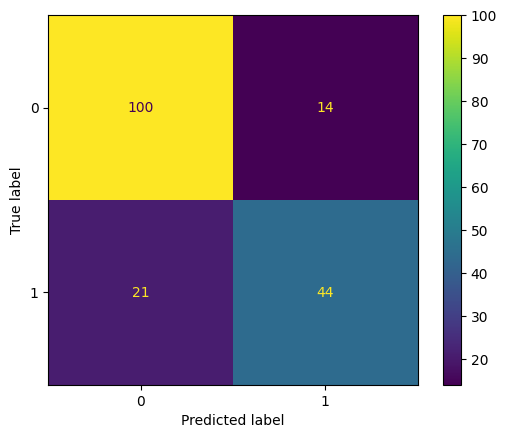

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [24]:
from sklearn.metrics import recall_score, precision_score

print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

Recall: 0.676923076923077
Precision: 0.7586206896551724


In [25]:
pipe

/home/vscode/.local/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('drop',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('col_dropper', 'drop',
                                                  ['PassengerId', 'Cabin',
                                                   'Name', 'Ticket']),
                                                 ('impute_num', SimpleImputer(),
                                                  ['Age', 'Fare']),
                                                 ('impute_cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])])),
                ('categorize',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_age',
                                                  FunctionT...
                                                  ['cat_age__impute_num__Age',
                                                   'cat_fare__impute_num__Fare',
                                                   'remainder__impute_cat__Embarked',
                                                   'remainder__remainder__Sex'])])),
                ('rename',
                 FunctionTransformer(func=<function rename_cols at 0x7347581349a0>)),
                ('svc',
                 GridSearchCV(cv=10, estimator=SVC(random_state=42),
                              param_grid={'C': [0.25, 0.5, 0.75, 1],
                                          'coef0': [0, 0.25, 0.5, 1],
                                          'kernel': ['rbf', 'poly'],
                                          'max_iter': [50, 100, 200]}))])

In [26]:
# Let's save this pipeline
# import joblib

# joblib.dump(pipe, "svc_pipeline.bz2")

['svc_pipeline.bz2']